# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
# импортируем необходимые модули и библиотеки
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# загружаем данные
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=13)

Found 7591 validated image filenames.


In [3]:
# посмотрим на размер выборки
print(labels.shape)

(7591, 2)


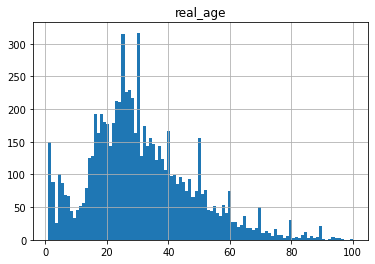

In [4]:
# Построим график распределения возраста в выборке
labels.hist(bins=100)
plt.show()

In [5]:
# Выведем числовые характеристики
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


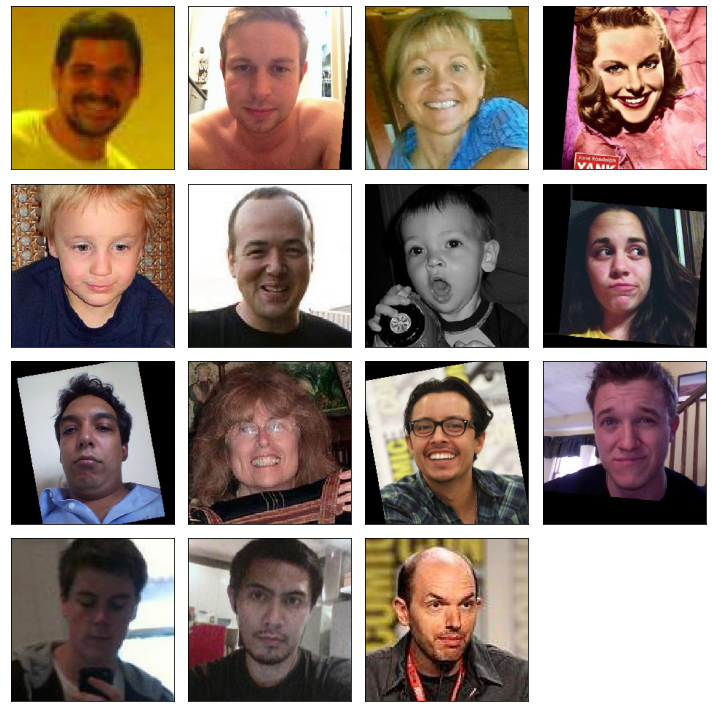

In [6]:
# Воспользуемся циклом для вывода на экран 15 фотографий и посмотрим, как устроен датасет
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод по результатам исследования.**

По размеру выборки видим, что она состоит из 7591 фотографий, что является небольшим набором данных для оценки возраста.
По числовым характеристикам можно сказать, что больше всего фотографий находится в диапазоне возраста от 20 до 41 года, а также в выборке присутствуют дети и старики.

Если судить по самим фотографиям, то возможно модели будет непросто оценивать возраст, так как на фото присутствуют различные аксесуары, такие как головные уборы, очки и прочие. Также некоторые фото имеют плохое разрешение и качество.

## Обучение модели

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=13)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=13)
    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 46s - loss: 204.0544 - mae: 10.4026 - val_loss: 569.2334 - val_mae: 18.7115
Epoch 2/10
356/356 - 38s - loss: 85.0805 - mae: 7.0213 - val_loss: 130.5484 - val_mae: 8.5445
Epoch 3/10
356/356 - 37s - loss: 55.9598 - mae: 5.6943 - val_loss: 85.8785 - val_mae: 7.0177
Epoch 4/10
356/356 - 37s - loss: 42.4062 - mae: 5.0196 - val_loss: 74.5577 - val_mae: 6.6045
Epoch 5/10
356/356 - 37s - loss: 35.2574 - mae: 4.4843 - val_loss: 96.0244 - val_mae: 7.2319
Epoch 6/10
356/356 - 37s - loss: 25.4450 - mae: 3.9045 - val_loss: 72.4047 - val_mae: 6.2903
Epoch 7/10
356/356 - 37s - loss: 21.6578 - mae: 3.5693 - val_loss: 82.6985 - val_mae: 6.8962
Epoch 8/10
356/356 - 37s - loss: 18.1696 - mae: 3.2789 - val_loss: 69.4618 - val_mae: 6.2506
Epoch 9/10
356/356 - 38s - loss: 16.6861 - mae: 3.0803 - val_loss: 69.1191 - val_mae: 6.0844
Epoch 10/10
356/356 - 37s - loss: 14.1987 - mae: 2.8415 - val_loss: 66.7266 - val_mae: 6.0516
119/119 - 9s - loss: 66.7266 - mae: 6.0516
Test MAE: 6.0516
```

## Анализ обученной модели

По окончании обучения модели мы видим, что полученное значение **MAE равное 6.0516** это хороший показатель, так как для определения категории пользователей с погрешностью примерно в 6 лет это не критично, а значит наша модель позволяет с большой точностью предсказывать возраст покупателей. Возможно это происходит по причине того, что категории пользователей разделяют по возрасту 8-12 лет. Также можно отметить, что использование GPU и нейронных сетей позволяет быстро и эффективно обработать большое количество информации с высокой точностью.